## Import data and modules

In [1]:
import pandas as pd
import hddm

data = hddm.load_csv('risk_data.csv')

/anaconda3/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


## Regression model

In [22]:
model = hddm.HDDMRegressor(data, ['v ~ gain + loss', 'a ~ loss'], p_outlier=0.05, include=('z', 'sz'), group_only_regressors=False)

Adding these covariates:
['v_Intercept', 'v_gain', 'v_loss']
Adding these covariates:
['a_Intercept', 'a_loss']


In [24]:
model.find_starting_values()

In [25]:
model.sample(2500, burn=1000)

 [-----------------100%-----------------] 2501 of 2500 complete in 28148.1 sec

## Checking convergence

Plotting z


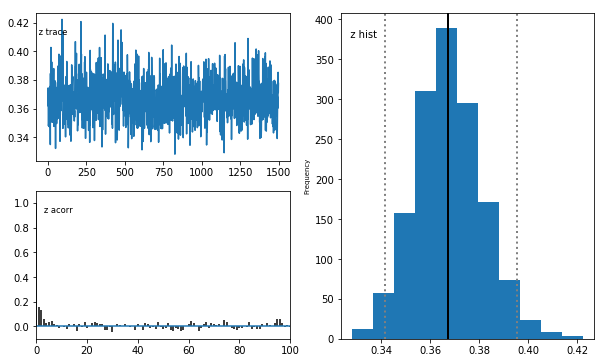

In [27]:
model.plot_posteriors(['z'])

## Results

In [77]:
import numpy as np
numSubjects = 49
lambdas = []
for subjectIndex in range(1, numSubjects+1):
    df = model.nodes_db
    beta_gain = df.loc['v_gain_subj.{}'.format(subjectIndex), 'mean']
    beta_loss = df.loc['v_loss_subj.{}'.format(subjectIndex), 'mean']
    lambdas.append(beta_loss/beta_gain)

lambda_mean = np.mean(lambdas)
print("Mean value of lambda: ", lambda_mean)

('Subject: ', 1, 'Beta_G = ', 0.01838115944114609, 'Beta_L = ', 0.021203072659599368, 'Lambda = ', 1.1535220467179261)
('Subject: ', 2, 'Beta_G = ', 0.021005699729300373, 'Beta_L = ', 0.03494140062642144, 'Lambda = ', 1.6634247407470304)
('Subject: ', 3, 'Beta_G = ', 0.006965907949608007, 'Beta_L = ', 0.024957009209781292, 'Lambda = ', 3.5827360037374163)
('Subject: ', 4, 'Beta_G = ', 0.03082015972064867, 'Beta_L = ', 0.03094989210281748, 'Lambda = ', 1.004209335167134)
('Subject: ', 5, 'Beta_G = ', 0.009199342742712032, 'Beta_L = ', 0.03096416188979231, 'Lambda = ', 3.365910234654857)
('Subject: ', 6, 'Beta_G = ', 0.00924943907824226, 'Beta_L = ', 0.013558518843753755, 'Lambda = ', 1.4658747118674338)
('Subject: ', 7, 'Beta_G = ', 0.012325015479770116, 'Beta_L = ', 0.015938272604364423, 'Lambda = ', 1.2931645100588305)
('Subject: ', 8, 'Beta_G = ', 0.025179460072192603, 'Beta_L = ', 0.020721997908704565, 'Lambda = ', 0.8229722896873902)
('Subject: ', 9, 'Beta_G = ', 0.0086773754441504

In [79]:
# a = a_intercept + a_loss x loss
# loss = 10, 20, 30, 40, 50, 60, 70, 80, 90, 100
import numpy as np
allLosses = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
def a_mean_participant(a_intercept, a_loss):
    all_a = []
    for loss in allLosses:
        a = a_intercept + a_loss*loss
        all_a.append(a)
    
    mean_a = np.mean(all_a)
    return mean_a 

db = model.nodes_db
def getACovariatesForParticipant(participantIndex):
    a_intercept = db.loc['a_Intercept_subj.{}'.format(participantIndex), 'mean']
    a_loss = db.loc['a_loss_subj.{}'.format(participantIndex), 'mean']
    
    return a_intercept, a_loss

numParticipants = 49
allA = []
for participantIndex in range(1, numParticipants+1):
    participant_a = a_mean_participant(*getACovariatesForParticipant(participantIndex))
    allA.append(participant_a)
    
print("Mean value of a: ", np.mean(allA))

('Mean value of a: ', 1.6386447793075938)


In [63]:
# mean value of the bias
allZ = []
for participantIndex in range(1, numParticipants+1):
    z_participant = db.loc['z_subj.{}'.format(participantIndex), 'mean']
    z_adjusted = (z_participant - 0.5)*allA[participantIndex-1]
    allZ.append(z_adjusted)
    
mean_Z = np.mean(allZ)
print("Mean value of Bias: ", mean_Z)

('Mean value of Bias: ', -0.1815244780067507)


## Constrained models - No Loss Aversion

In [72]:
data_no_lossAversion = data.copy()
data_no_lossAversion['net'] = data_no_lossAversion.apply(lambda row: row['gain']+row['loss'], axis=1)

model_no_lossAversion = hddm.models.HDDMRegressor(data_no_lossAversion, ['v ~ net', 'a ~ loss'], include=('z'), group_only_regressors=False)
model_no_lossAversion.find_starting_values()

Adding these covariates:
['v_Intercept', 'v_net']
Adding these covariates:
['a_Intercept', 'a_loss']


In [73]:
model_no_lossAversion.sample(2500, burn=1000)

 [-----------------100%-----------------] 2501 of 2500 complete in 14489.8 sec

In [80]:
model_no_lossAversion.print_stats()

                            mean          std         2.5q          25q          50q          75q        97.5q       mc err
t                       0.427871    0.0151952     0.399336     0.417679     0.427646      0.43776     0.457997  0.000513334
t_std                   0.110287     0.013255    0.0878151     0.100999     0.108836     0.118002     0.139878   0.00052772
t_subj.1                0.406186    0.0308965     0.341298     0.387272     0.408356      0.42685     0.461222   0.00138487
t_subj.2                0.457686    0.0105337     0.433956      0.45127     0.459043     0.465321     0.474176  0.000478942
t_subj.3                0.385912    0.0264525     0.327971     0.369928     0.388781     0.404067     0.431273   0.00110671
t_subj.4                0.613498    0.0193101     0.570255     0.603118     0.614724     0.627049     0.646323  0.000847037
t_subj.5                0.362933    0.0149686     0.327526     0.354643     0.365555     0.373767     0.384979  0.000871528
t_subj.6